In [1]:
import sys
import numpy as np
import librosa

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import os

# import chainer
# from chainer import cuda, Variable, Chain, serializers
# import chainer.functions as F
# import chainer.links as L

# sys.path.append('../networks/')
from network import *

%matplotlib inline
import matplotlib.pyplot as plt

# plt.style.use('ggplot')

In [11]:
logmel_Res = []
freqs = range(22050, 0, -30)
wav_len = int(44100 * 1.5)
fs = 44100

for freq in freqs:
#     response = np.zeros([64])
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
    melspec = librosa.feature.melspectrogram(x, 44100, n_fft=512, hop_length=150, n_mels=32) # (64, 442)
    logmel = librosa.logamplitude(melspec) # (64, 442)
    res = np.mean(logmel[:, 10: 140], axis=1) # (64,)
    logmel_Res.append(res)
    
logmel_Res = np.array(logmel_Res) # (800, 64)
print(logmel_Res)
print(logmel_Res.shape)
# mel_freq = 7995 - 10 * np.argmax(logmel_Res, axis=0)
# print mel_freq

[[-100.         -100.         -100.         ..., -100.         -100.         -100.        ]
 [ -86.37309092  -86.37309092  -86.37309092 ...,  -86.37309092
   -85.26454375   -8.7483568 ]
 [ -85.73983011  -85.73983011  -85.73983011 ...,  -85.73983011
   -85.25334373   -6.27744339]
 ..., 
 [  20.72316442   12.10464559  -27.81696003 ...,  -59.23412319
   -59.23412319  -59.23412319]
 [  19.62387598    6.72801207  -16.9482627  ...,  -59.73517487
   -59.73517487  -59.73517487]
 [  17.45246302   -2.22149856  -19.71532425 ...,  -60.06509643
   -60.06509643  -60.06509643]]
(735, 32)


In [12]:
mel_freq = 22050 -30 * np.argmax(logmel_Res, axis=0)
print(mel_freq, mel_freq.shape)

[  120   240   360   480   600   720   840   960  1110  1260  1410  1590
  1800  2070  2340  2640  3000  3390  3840  4350  4920  5580  6330  7170
  8100  9210 10410 11820 13380 15150 17160 19470] (32,)


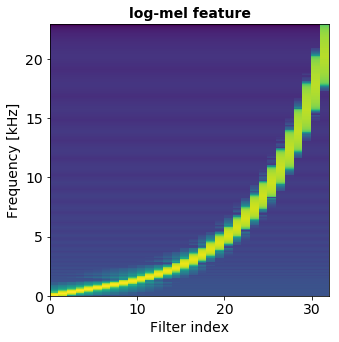

In [13]:
fig = plt.figure(figsize=(5, 5))

x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23) # (735, 65) (735, 65)
# print x.shape, y.shape
# print x
# print y
# plt.pcolor(x, y, np.flipud(logmel_Res)) # np.flipud 矩阵上下翻转
plt.pcolor(x, y, np.flipud(logmel_Res)) # np.flipud 矩阵上下翻转
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., 'm')
plt.title('log-mel feature', fontsize=14, fontweight='bold')
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

In [14]:
# Create sin waves

# freqs = range(7995, 0, -10)
freqs = range(22050, 0, -30)
wav_len = int(44100 * 1.5)

fs = 44100
X = []

for freq in freqs:
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
    X.append(x[np.newaxis, :])
X = np.array(X).astype(np.float32) # (735, 1, fs*1.5)
print(X.shape)

(735, 1, 66150)


In [36]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

# model = torch.load('../model/M9_fold1_v2_epoch250.pkl')
model = torch.load('../model/M9_fixed_logmel_fold1_p1_v3_more.pkl')

model.cuda()

# print model
# Calculate pool2 of EnvNet
batchsize = 32
Res1 = []
Res2 = []
Res3 = []
N = 735

Xt = torch.from_numpy(X)
Xt = Xt.cuda()
Xt = Variable(Xt)
for i in range(0, N, batchsize):
    print(i)
    x = Xt[i: i+batchsize]
    x1 = model.relu(model.bn1_1(model.conv1_1(x)))
    x2 = model.relu(model.bn1_2(model.conv1_2(x)))
    x3 = model.relu(model.bn1_3(model.conv1_3(x)))

    x1 = model.relu(model.bn2_1(model.conv2_1(x1)))
    x2 = model.relu(model.bn2_2(model.conv2_2(x2)))
    x3 = model.relu(model.bn2_3(model.conv2_3(x3)))
    
    x1 = model.pool2_1(x1)
    x2 = model.pool2_2(x2)
    x3 = model.pool2_3(x3)  # (batchSize, 64L, 441L)
        
    res1 = torch.mean(x1, dim=2)
    Res1.extend(res1.data.cpu().numpy())

    res2 = torch.mean(x2, dim=2)
    Res2.extend(res2.data.cpu().numpy())
    
    res3 = torch.mean(x3, dim=2)
    Res3.extend(res3.data.cpu().numpy())
# print Res
Res1 = np.asarray(Res1)
Res2 = np.asarray(Res2)
Res3 = np.asarray(Res3)

print(Res1.shape)
print(Res2.shape)
print(Res3.shape)

/home/zbq/work/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'network.M9_fixed_logmel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
(735, 32)
(735, 32)
(735, 32)


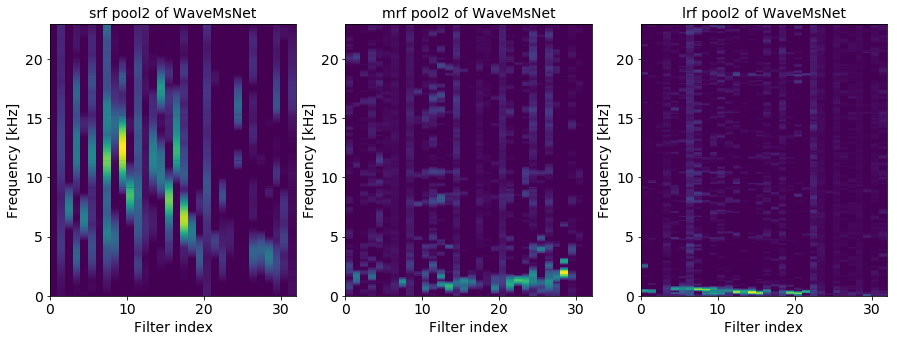

In [37]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(Res1))
plt.title('srf pool2 of WaveMsNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1,3,2)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(Res2))
plt.title('mrf pool2 of WaveMsNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1,3,3)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(Res3))
plt.title('lrf pool2 of WaveMsNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

sort_index1:  [28 19 26 27 21 30 23 18 12  6  4 17  2 15 22 10 11 20 13  7  5  3 16  9  1
  8 24 29 31 14 25  0]
sorted_Res1:  [[ 0.13803706  0.14509071  0.03757594 ...,  0.1663786   0.          0.13816988]
 [ 0.06264824  0.0404468   0.03154562 ...,  0.07129977  0.          0.03441214]
 [ 0.14690611  0.0589022   0.11685492 ...,  0.14922731  0.          0.04282266]
 ..., 
 [ 0.06328639  0.11416658  0.03016402 ...,  0.13262615  0.          0.09216927]
 [ 0.04914289  0.08704347  0.01851962 ...,  0.11455654  0.          0.07119549]
 [ 0.03043833  0.05701222  0.00816972 ...,  0.09205421  0.          0.04321791]] (735, 32)
scf:  [ 3240  3240  3570  3810  4440  4620  4800  5280  5580  6060  6240  6240
  7080  7830  8130  8220  8220  9090 10950 11100 11370 11460 11730 11910
 12000 14100 15600 15690 16350 16830 22050 22050]
5056.875 9652 2243 636


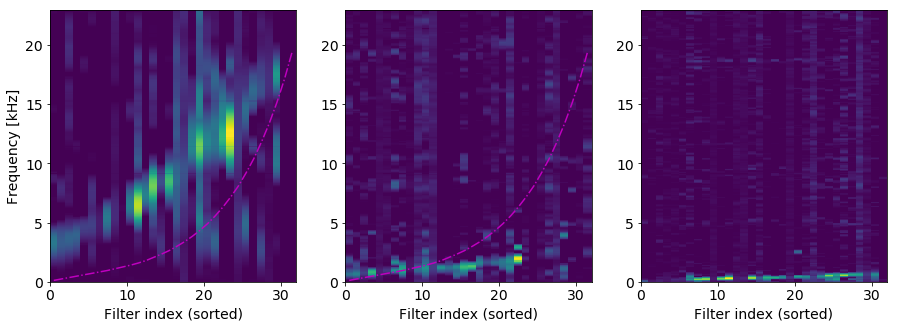

In [38]:
center_freq1 = 22050 - 30 * np.argmax(Res1, axis=0)
# print Res1
# print Res1.shape
# print np.argmax(Res1, axis=0)
# print center_freq1, center_freq1.shape
center_freq2 = 22050 - 30 * np.argmax(Res2, axis=0)
center_freq3 = 22050 - 30 * np.argmax(Res3, axis=0)
# rm_index = [5, 6, 7, 8, 18] # filters which respond to all frequency area are removed
# center_freq[rm_index] = 8000
sort_index1 = np.argsort(center_freq1)[:33]
sort_index2 = np.argsort(center_freq2)[:33]
sort_index3 = np.argsort(center_freq3)[:33]

print('sort_index1: ', sort_index1)

sorted_Res1 = Res1[:, sort_index1]
sorted_Res2 = Res2[:, sort_index2]
sorted_Res3 = Res3[:, sort_index3]

print('sorted_Res1: ', sorted_Res1, sorted_Res1.shape)

sorted_center_freq1 = center_freq1[sort_index1]
sorted_center_freq2 = center_freq2[sort_index2]
sorted_center_freq3 = center_freq3[sort_index3]
print('scf: ', sorted_center_freq1)

avg_mel = np.mean(mel_freq)
avg_center_freq1 = int(np.mean(center_freq1))
avg_center_freq2 = int(np.mean(center_freq2))
avg_center_freq3 = int(np.mean(center_freq3))
print(avg_mel, avg_center_freq1, avg_center_freq2, avg_center_freq3)

fig = plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(sorted_Res1), linewidth=0, rasterized=True)
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., 'm')
plt.plot(np.arange(32) * (32) / 32. + 0.5 , mel_freq / 1000., color='m', linestyle='-.')
# plt.title('scale Stk I responses(sorted)', fontsize=14)
plt.xlabel('Filter index (sorted)', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)
# plt.colorbar()

plt.subplot(1, 3, 2)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(sorted_Res2), linewidth=0, rasterized=True)
plt.plot(np.arange(32) * (32) / 32. + 0.5 , mel_freq / 1000., color='m', linestyle='-.')
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq2 / 1000., 'm')
# plt.title('mrf responses(sorted)', fontsize=14)
plt.xlabel('Filter index (sorted)', fontsize=14)
# plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 3)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(sorted_Res3), linewidth=0, rasterized=True)
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., 'm')
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq3 / 1000., 'm')
# plt.title('lrf responses(sorted)', fontsize=14)
plt.xlabel('Filter index (sorted)', fontsize=14)
# plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig('responses_mrf.pdf', bbox_inches='tight')

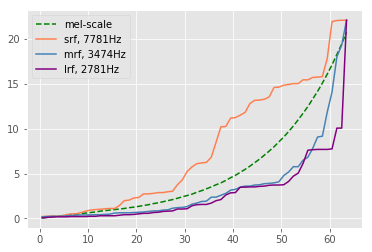

In [140]:
fig = plt.figure()
plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., label='mel-scale', color='g', linestyle='--')
plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq1 / 1000., label='srf, '+str(avg_center_freq1)+'Hz', color='coral')
plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq2 / 1000., label='mrf, '+str(avg_center_freq2)+'Hz', color='steelblue')
plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq3 / 1000., label='lrf, '+str(avg_center_freq3)+'Hz', color='purple')
plt.legend(loc='upper left')
plt.show()

# plt.savefig('center f.pdf', bbox_inches='tight')

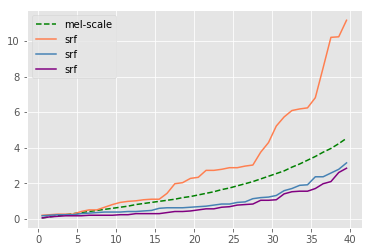

In [92]:
fig = plt.figure()
plt.plot(np.arange(40) * (40) / 40. + 0.5 , mel_freq[:40] / 1000., label='mel-scale', color='g', linestyle='--')
plt.plot(np.arange(40) * (40) / 40. + 0.5 , sorted_center_freq1[:40] / 1000., label='srf, ', color='coral')
plt.plot(np.arange(40) * (40) / 40. + 0.5 , sorted_center_freq2[:40] / 1000., label='mrf', color='steelblue')
plt.plot(np.arange(40) * (40) / 40. + 0.5 , sorted_center_freq3[:40] / 1000., label='lrf', color='purple')
plt.legend(loc='upper left')
plt.show()


In [34]:
np.savetxt('../figures/txt/response.txt', Res)
np.savetxt('../figures/txt/sorted_response.txt', sorted_Res)
np.savetxt('../figures/txt/logmel_response.txt', logmel_Res)
np.savetxt('../figures/txt/mel_freq.txt', mel_freq)